In [1]:
import matplotlib.pyplot as plt
#matplotlib inline
import numpy as np
from keras.utils import to_categorical

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]





Using TensorFlow backend.
/Users/victort-d/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [50]:
def centre_gravite(dataset,size):
    res = np.zeros((size, 6))
    for i in range(0, size):
        x_CG = (dataset[i,4] + dataset[i,2] + dataset[i,0])/3
        y_CG = (dataset[i,5] + dataset[i,3] + dataset[i,1])/3
        minmax = [dataset[i,2*m] for m in range(0,3)]
        j = np.argmax(minmax)
        k = np.argmin(minmax)
        temp = [dataset[i,2*j] - x_CG, dataset[i,2*j+1] - y_CG, 
                dataset[i,2*k] - x_CG, dataset[i,2*k+1] - y_CG, 
                x_CG, y_CG]
        res[i,:] = temp
    return res


def rearrange_triangle(dataset,size):
    res = np.zeros((size, 6))
    for i in range(0, size):
        x_manquant = dataset[i,4] - dataset[i,2] - dataset[i,0]
        y_manquant = dataset[i,5] - dataset[i,3] - dataset[i,1]
        temp = [dataset[i,0] + dataset[i,4], dataset[i,1] + dataset[i,5], 
                dataset[i,2] + dataset[i,4], dataset[i,3] + dataset[i,5], 
                x_manquant, y_manquant]
       
        res[i,:] = temp
    return res

In [3]:
[X_train2, Y_train2] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [4]:
import keras
from keras.models import Sequential
import keras.backend as K
K.clear_session()
model = Sequential()

from keras.utils import to_categorical
Y_train2_t = to_categorical(Y_train2, num_classes=3)
from keras.layers import Dense, Activation

nb_neurons = 20
model.add(Dense(nb_neurons, input_shape=(5184,)))
model.add(Activation('relu'))
model.add(Dense(3, activation = 'softmax'))

In [5]:
from keras.optimizers import SGD
sgd = SGD(lr=0.0001,
          decay=1e-6, momentum=0.9,
nesterov=True)
  
model.compile(loss='categorical_crossentropy',
              optimizer=sgd, metrics=['accuracy'])

In [6]:
model.fit(X_train2, Y_train2_t, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 0s 656us/step - loss: 1.2904 - acc: 0.3467
Epoch 2/20
300/300 [==============================] - 0s 120us/step - loss: 1.0250 - acc: 0.4900
Epoch 3/20
300/300 [==============================] - 0s 94us/step - loss: 0.9164 - acc: 0.6133
Epoch 4/20
300/300 [==============================] - 0s 98us/step - loss: 0.8616 - acc: 0.6067
Epoch 5/20
300/300 [==============================] - 0s 100us/step - loss: 0.8106 - acc: 0.6767
Epoch 6/20
300/300 [==============================] - 0s 101us/step - loss: 0.7767 - acc: 0.6633
Epoch 7/20
300/300 [==============================] - 0s 117us/step - loss: 0.7482 - acc: 0.6933
Epoch 8/20
300/300 [==============================] - 0s 95us/step - loss: 0.7271 - acc: 0.6800
Epoch 9/20
300/300 [==============================] - 0s 94us/step - loss: 0.7057 - acc: 0.6867
Epoch 10/20
300/300 [==============================] - 0s 91us/step - loss: 0.6902 - acc: 0.6933
Epoch 11/20
300/300 [=============

In [7]:
X_test2 = generate_a_disk()
X_test2 = X_test2.reshape(1, X_test2.shape[0])
model.predict(X_test2)

array([[  6.68509721e-35,   1.00000000e+00,   0.00000000e+00]], dtype=float32)

In [106]:
import keras
from keras.models import Sequential
import keras.backend as K
K.clear_session()
model1 = Sequential()

from keras.utils import to_categorical
Y_train2_t = to_categorical(Y_train2, num_classes=3)
from keras.layers import Dense, Activation

nb_neurons = 30
model1.add(Dense(nb_neurons, input_shape=(5184,)))
model1.add(Activation('relu'))
model1.add(Dense(3, activation = 'softmax'))

In [107]:
from keras.optimizers import Adam
adam = Adam(lr=0.0001)

model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [123]:
model1.fit(X_train2, Y_train2_t, epochs=20, batch_size=32)


Epoch 1/20
300/300 [==============================] - 0s 104us/step - loss: 0.0049 - acc: 1.0000
Epoch 2/20
300/300 [==============================] - 0s 97us/step - loss: 0.0048 - acc: 1.0000
Epoch 3/20
300/300 [==============================] - 0s 126us/step - loss: 0.0049 - acc: 1.0000
Epoch 4/20
300/300 [==============================] - 0s 108us/step - loss: 0.0048 - acc: 1.0000
Epoch 5/20
300/300 [==============================] - 0s 102us/step - loss: 0.0047 - acc: 1.0000
Epoch 6/20
300/300 [==============================] - 0s 106us/step - loss: 0.0048 - acc: 1.0000
Epoch 7/20
300/300 [==============================] - 0s 124us/step - loss: 0.0048 - acc: 1.0000
Epoch 8/20
300/300 [==============================] - 0s 128us/step - loss: 0.0048 - acc: 1.0000
Epoch 9/20
300/300 [==============================] - 0s 124us/step - loss: 0.0045 - acc: 1.0000
Epoch 10/20
300/300 [==============================] - 0s 150us/step - loss: 0.0045 - acc: 1.0000
Epoch 11/20
300/300 [=========

In [118]:
X_test2 = generate_a_disk()
X_test2 = X_test2.reshape(1, X_test2.shape[0])
model1.predict(X_test2)

array([[ 0.,  1.,  0.]], dtype=float32)

# Question 3

In [124]:
weights1 = model1.get_weights()[0].reshape(72,72,30)
weights2 = model1.get_weights()[2]

weights = np.dot(weights1, weights2)
weights.shape

(72, 72, 3)

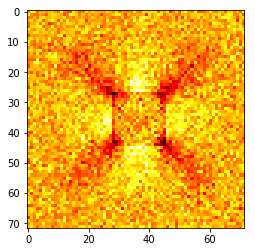

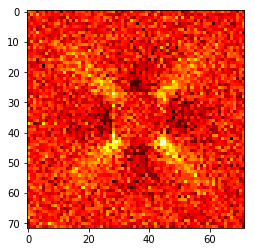

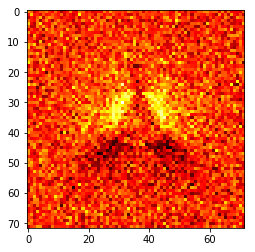

In [125]:
for i in range(3):
    plt.imshow(weights[:,:,i], cmap = "hot")
    plt.show()

# Question 4

In [14]:
[X_train4, Y_train4] = generate_dataset_classification(1000, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [126]:
X_train4_t = X_train4.reshape(-1,72,72,1)

In [127]:
import keras
from keras.models import Sequential
import keras.backend as K
K.clear_session()
model4 = Sequential()

from keras.utils import to_categorical
Y_train4_t = to_categorical(Y_train4, num_classes=3)
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

nb_neurons = 30 

model4.add(Conv2D(filters=32, kernel_size=[5, 5], input_shape=(72,72,1)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Flatten())
model4.add(Dense(nb_neurons, input_shape=(72,72,)))
model4.add(Activation('relu'))
model4.add(Dense(3, activation = 'softmax'))

In [128]:
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [129]:
model4.fit(X_train4_t, Y_train4_t, epochs=20, batch_size=32)

Epoch 1/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.1977 - acc: 0.4870
Epoch 2/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7372 - acc: 0.6890
Epoch 3/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6468 - acc: 0.7420
Epoch 4/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5622 - acc: 0.7850
Epoch 5/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4950 - acc: 0.8150
Epoch 6/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4508 - acc: 0.8370
Epoch 7/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3858 - acc: 0.8800
Epoch 8/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3674 - acc: 0.8800
Epoch 9/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3544 - acc: 0.8780
Epoch 10/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2916 - acc: 0.9090
Epoch 11/20
1000/1000 [======

In [19]:
[X_test4, Y_test4] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [20]:
X_test4_t = X_test4.reshape(300,72,72,1)

In [21]:
model4.evaluate(X_test4_t, Y_test4)

300/300 [==============================] - 0s 1ms/step


[0.50151954253514608, 0.76666666666666672]

# Question 5

In [22]:
[X_train5, Y_train5] = generate_dataset_regression(1000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [69]:
import keras
from keras.models import Sequential
import keras.backend as K
K.clear_session()
model5 = Sequential()

from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, Dropout
nb_neurons = 64
model5.add(Conv2D(filters=32, kernel_size=[5, 5], input_shape=(72,72,1)))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Flatten())
model5.add(Dropout(0.25))
model5.add(Dense(nb_neurons, input_shape=(72,72,)))
model5.add(Activation('relu'))
model5.add(Dense(6, activation = 'linear'))

In [70]:
from keras.optimizers import Adam
adam = Adam(lr=0.0001)

model5.compile(loss='mean_squared_error',
              optimizer=adam)

In [25]:
[X_test5, Y_test5] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [71]:
X_train5_t = X_train5.reshape(-1,72,72,1)
X_test5_t = X_test5.reshape(-1,72,72,1)

In [72]:
Y_train5_sorted = centre_gravite(Y_train5, 1000)
Y_test5_sorted = centre_gravite(Y_test5, 300)

In [43]:
Y_train5[0]

array([ 0.71986584,  0.92000602,  0.31926686,  0.97619732,  0.56522072,
        0.02423682])

In [44]:
Y_train5_sorted[0]

array([ 0.18508136,  0.2798593 , -0.21551761,  0.3360506 ,  0.53478448,
        0.64014672])

In [52]:
Y_train5_final[0]

array([ 0.71986584,  0.92000602,  0.31926686,  0.97619732,  0.56522072,
        0.02423682])

In [88]:
model5.fit(X_train5_t, Y_train5_sorted, validation_data = (X_test5_t, Y_test5_sorted), epochs=20, batch_size=32)

Train on 1000 samples, validate on 300 samples
Epoch 1/20
1000/1000 [==============================] - 4s 4ms/step - loss: 9.6664e-04 - val_loss: 0.0141
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/step - loss: 9.8199e-04 - val_loss: 0.0142
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 9.5790e-04 - val_loss: 0.0141
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 9.1946e-04 - val_loss: 0.0145
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/step - loss: 9.7966e-04 - val_loss: 0.0143
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 9.1857e-04 - val_loss: 0.0141
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/step - loss: 9.1352e-04 - val_loss: 0.0143
Epoch 8/20
1000/1000 [==============================] - 4s 4ms/step - loss: 9.3423e-04 - val_loss: 0.0140
Epoch 9/20
1000/1000 [==============================] - 4s 4ms/step - loss: 9.4798e-04 - val_loss: 0.0140

In [89]:
Y_test5_final = rearrange_triangle(Y_test5_sorted,300)
Y_test5_predictionfinal = rearrange_triangle(model5.predict(X_test5_t), 300)
Y_train5_final = rearrange_triangle(Y_train5_sorted,1000)
Y_train5_predictionfinal = rearrange_triangle(model5.predict(X_train5_t),1000)

In [90]:
model5.evaluate(X_test5_t, Y_test5_sorted)

300/300 [==============================] - 0s 1ms/step


0.013848887085914611

In [91]:
model5.evaluate(X_train5_t, Y_train5_sorted)

1000/1000 [==============================] - 1s 1ms/step


0.000327523005194962

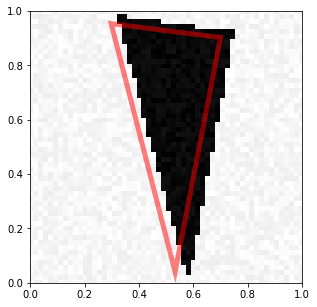

In [92]:
visualize_prediction(X_train5_t[0,:,:],Y_train5_predictionfinal[0])

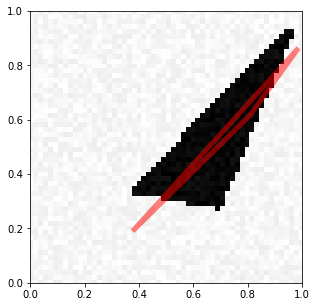

In [93]:
visualize_prediction(X_test5_t[0,:,:],Y_test5_predictionfinal[0])